In [0]:
import os
import sys
import cv2 as cv
import numpy  as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## ***TRANSFER LEARNING***

In [0]:
def creating_train(path, cinematica):
  X_train, y_train, paths = [], [], []
  for folder_path in path:
    path_P1 = folder_path.strip().split(" ")[:2]
    path_P = '/content/gdrive/My Drive/PROYECT_HEART/DATASETS/SUNNYBROOK/'+cinematica+'/'+ path_P1[0] +"/"+path_P1[1]+"/"
    paths.append(path_P)
    folders_P1 = sorted(glob(os.path.join(path_P, '*.jpg')))
    for images in folders_P1:
        img = plt.imread(images)
        img = cv.resize(img, (224,224))
        X_train.append(img)
        y_train.append(path_P1[0][0])
  return np.array(X_train), np.array(paths), np.array(y_train)

In [0]:
first = ['0-HF-I-01 7','0-HF-I-02 3','0-HF-I-05 7','0-HF-I-06 4','0-HF-I-07 4','0-HF-I-08 3','0-HF-I-09 9','0-HF-I-10 9','0-HF-I-11 3','0-HF-I-12 2','0-HF-I-40 4',
         '1-HF-NI-03 3','1-HF-NI-04 2','1-HF-NI-07 3','1-HF-NI-11 8','1-HF-NI-12 4','1-HF-NI-13 8','1-HF-NI-14 8','1-HF-NI-15 6','1-HF-NI-31 6','1-HF-NI-33 3','1-HF-NI-34 8','1-HF-NI-36 6',
         '2-HYP-01 4','2-HYP-03 3','2-HYP-06 6','2-HYP-07 7','2-HYP-08 5','2-HYP-09 8','2-HYP-10 2','2-HYP-11 8','2-HYP-12 3','2-HYP-37 7','2-HYP-38 3','2-HYP-40 5',
         '3-N-02 6','3-N-03 9','3-N-05 3','3-N-06 6','3-N-07 9','3-N-09 7','3-N-10 8','3-N-11 2','3-N-40 8']

In [0]:
X_train_ppm, paths_ppm, y_train = creating_train(first, 'SB_PPM')
#y_train = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]
#y_train = np.array(y_train)
print("Número de pacientes: ", X_train_ppm.shape, paths_ppm.shape)
print("Número de clases:    ", int(np.unique(y_train)[-1])+1)
X_train, X_test, y_train, y_test = train_test_split(X_train_ppm, y_train, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Número de pacientes:  (880, 224, 224, 3) (44,)
Número de clases:     4
(704, 224, 224, 3) (176, 224, 224, 3) (704,) (176,)


In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


X_train /= 255
X_test /= 255
print('X_train shape:               ', X_train.shape)
print('Number of images in X_train: ', X_train.shape[0])
print('Number of images in X_test:  ', X_test.shape[0])

X_train shape:                (704, 224, 224, 3)
Number of images in X_train:  704
Number of images in X_test:   176


In [9]:
mobile_net = tf.keras.applications.MobileNet(weights='imagenet')

W0819 15:01:25.967395 140280332031872 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


17227776/17225924 [==============================] - 0s 0us/step


In [10]:
model_heart = tf.keras.models.Sequential(mobile_net.layers[:-2])
model_heart.add(tf.keras.layers.GlobalAvgPool2D(input_shape=(1,1,2048)))
model_heart.add(tf.keras.layers.Dense(4, activation='sigmoid'))
for layer in model_heart.layers[:-1]:
    layer.trainable = False
model_heart.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0

In [0]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model_heart.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model_heart.fit(X_train, y_train, epochs=20, batch_size=64,validation_data=(X_test, y_test))

W0818 03:00:13.481199 140699573675904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 704 samples, validate on 176 samples
Epoch 1/20
704/704 [==============================] - 6s 9ms/sample - loss: 1.6673 - acc: 0.3182 - val_loss: 2.1584 - val_acc: 0.3807
Epoch 2/20
704/704 [==============================] - 1s 2ms/sample - loss: 1.0725 - acc: 0.5185 - val_loss: 1.9495 - val_acc: 0.3864
Epoch 3/20
704/704 [==============================] - 1s 2ms/sample - loss: 0.8976 - acc: 0.5923 - val_loss: 2.1683 - val_acc: 0.3693
Epoch 4/20
704/704 [==============================] - 1s 2ms/sample - loss: 0.7362 - acc: 0.6406 - val_loss: 2.4359 - val_acc: 0.4602
Epoch 5/20
704/704 [==============================] - 1s 2ms/sample - loss: 0.5995 - acc: 0.6889 - val_loss: 2.2398 - val_acc: 0.5568
Epoch 6/20
704/704 [==============================] - 1s 2ms/sample - loss: 0.4839 - acc: 0.7599 - val_loss: 1.8928 - val_acc: 0.6023
Epoch 7/20
704/704 [==============================] - 1s 2ms/sample - loss: 0.3983 - acc: 0.7855 - val_loss: 1.7275 - val_acc: 0.6364
Epoch 8/20
704/7

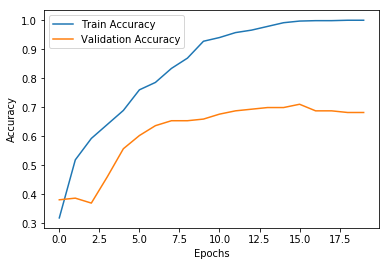

In [0]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
trans_model = tf.keras.models.Sequential(mobile_net.layers[:-2])
for layer in trans_model.layers[:-1]:
    layer.trainable = False    
trans_model.add(tf.keras.layers.GlobalAvgPool2D(input_shape=(1,1,512)))
trans_model.add(tf.keras.layers.Dense(512))
trans_model.add(tf.keras.layers.BatchNormalization())
trans_model.add(tf.keras.layers.Activation('relu'))
trans_model.add(tf.keras.layers.Dense(254,))
trans_model.add(tf.keras.layers.BatchNormalization())
trans_model.add(tf.keras.layers.Activation('relu'))
trans_model.add(tf.keras.layers.Dropout(0.2))
trans_model.add(tf.keras.layers.Dense(128))
trans_model.add(tf.keras.layers.BatchNormalization())
trans_model.add(tf.keras.layers.Activation('relu'))
trans_model.add(tf.keras.layers.Dropout(0.2))
trans_model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
trans_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)     

In [0]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
trans_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_trans = trans_model.fit(X_train, y_train, epochs=20, batch_size=32,validation_data=(X_test, y_test))

Train on 704 samples, validate on 176 samples
Epoch 1/20
704/704 [==============================] - 3s 5ms/sample - loss: 1.3378 - acc: 0.3665 - val_loss: 1.4234 - val_acc: 0.2330
Epoch 2/20
704/704 [==============================] - 1s 2ms/sample - loss: 1.1513 - acc: 0.5568 - val_loss: 1.3408 - val_acc: 0.2898
Epoch 3/20
704/704 [==============================] - 1s 2ms/sample - loss: 1.0161 - acc: 0.7358 - val_loss: 1.3084 - val_acc: 0.3011
Epoch 4/20
704/704 [==============================] - 1s 2ms/sample - loss: 0.9177 - acc: 0.8523 - val_loss: 1.2800 - val_acc: 0.3807
Epoch 5/20
704/704 [==============================] - 1s 2ms/sample - loss: 0.8233 - acc: 0.9034 - val_loss: 1.2528 - val_acc: 0.4205
Epoch 6/20
704/704 [==============================] - 1s 2ms/sample - loss: 0.7206 - acc: 0.9247 - val_loss: 1.2263 - val_acc: 0.4261
Epoch 7/20
704/704 [==============================] - 1s 2ms/sample - loss: 0.6308 - acc: 0.9631 - val_loss: 1.2049 - val_acc: 0.4375
Epoch 8/20
704/7

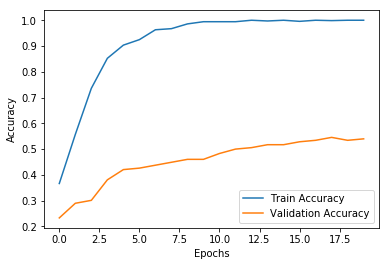

In [0]:
plt.plot(history_trans.history['acc'], label='Train Accuracy')
plt.plot(history_trans.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

***Flujo óptico***

In [0]:
X_train_OF, paths_OF, y_train_OF = creating_train(first, 'SB_OF')
print("Número de pacientes: ", X_train_OF.shape, paths_OF.shape)
print("Número de clases:    ", int(np.unique(y_train_OF)[-1])+1)
X_train_OF, X_test_OF, y_train_OF, y_test_OF = train_test_split(X_train_OF, y_train_OF, test_size=0.20)
print(X_train_OF.shape, X_test_OF.shape, y_train_OF.shape, y_test_OF.shape)

Número de pacientes:  (865, 224, 224, 3) (44,)
Número de clases:     4
(692, 224, 224, 3) (173, 224, 224, 3) (692,) (173,)


In [0]:
X_train_OF = X_train_OF.astype('float32')
X_test_OF = X_test_OF.astype('float32')


X_train_OF /= 255
X_test_OF /= 255
print('X_train shape:               ', X_train_OF.shape)
print('Number of images in X_train: ', X_train_OF.shape[0])
print('Number of images in X_test:  ', X_test_OF.shape[0])

X_train shape:                (692, 224, 224, 3)
Number of images in X_train:  692
Number of images in X_test:   173


In [0]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.8)
model_heart.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_OF = model_heart.fit(X_train_OF, y_train_OF, epochs=20, batch_size=64,validation_data=(X_test_OF, y_test_OF))

Train on 692 samples, validate on 173 samples
Epoch 1/20
692/692 [==============================] - 2s 3ms/sample - loss: 0.8323 - acc: 0.5448 - val_loss: 1.9042 - val_acc: 0.3468
Epoch 2/20
692/692 [==============================] - 1s 2ms/sample - loss: 0.8291 - acc: 0.5462 - val_loss: 1.8781 - val_acc: 0.3295
Epoch 3/20
692/692 [==============================] - 1s 2ms/sample - loss: 0.8142 - acc: 0.5694 - val_loss: 1.9004 - val_acc: 0.3237
Epoch 4/20
692/692 [==============================] - 1s 2ms/sample - loss: 0.7982 - acc: 0.5766 - val_loss: 1.9022 - val_acc: 0.3237
Epoch 5/20
692/692 [==============================] - 1s 2ms/sample - loss: 0.7992 - acc: 0.5809 - val_loss: 1.8897 - val_acc: 0.3121
Epoch 6/20
692/692 [==============================] - 1s 2ms/sample - loss: 0.7809 - acc: 0.6040 - val_loss: 1.8957 - val_acc: 0.3121
Epoch 7/20
692/692 [==============================] - 1s 2ms/sample - loss: 0.7726 - acc: 0.6113 - val_loss: 1.8930 - val_acc: 0.3064
Epoch 8/20
692/6

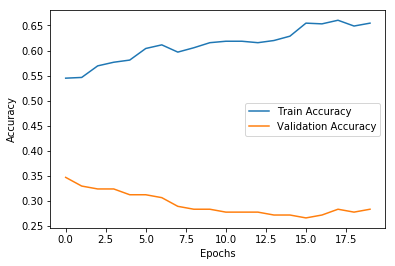

In [0]:
plt.plot(history_OF.history['acc'], label='Train Accuracy')
plt.plot(history_OF.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

***Aceleración normal***

In [7]:
X_train_AN, paths_AN, y_train_AN = creating_train(first, 'SB_AN')
print("Número de pacientes: ", X_train_AN.shape, paths_AN.shape)
print("Número de clases:    ", int(np.unique(y_train_AN)[-1])+1)
X_train_AN, X_test_AN, y_train_AN, y_test_AN = train_test_split(X_train_AN, y_train_AN, test_size=0.20)
print(X_train_AN.shape, X_test_AN.shape, y_train_AN.shape, y_test_AN.shape)

Número de pacientes:  (836, 224, 224, 3) (44,)
Número de clases:     4
(668, 224, 224, 3) (168, 224, 224, 3) (668,) (168,)


In [8]:
X_train_AN = X_train_AN.astype('float32')
X_test_AN = X_test_AN.astype('float32')


X_train_AN /= 255
X_test_AN /= 255
print('X_train shape:               ', X_train_AN.shape)
print('Number of images in X_train: ', X_train_AN.shape[0])
print('Number of images in X_test:  ', X_test_AN.shape[0])

X_train shape:                (668, 224, 224, 3)
Number of images in X_train:  668
Number of images in X_test:   168


In [11]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.8)
model_heart.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_AN = model_heart.fit(X_train_AN, y_train_AN, epochs=20, batch_size=64,validation_data=(X_test_AN, y_test_AN))

W0819 15:01:43.287805 140280332031872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 668 samples, validate on 168 samples
Epoch 1/20
668/668 [==============================] - 7s 11ms/sample - loss: 2.0698 - acc: 0.2695 - val_loss: 1.5355 - val_acc: 0.2440
Epoch 2/20
668/668 [==============================] - 2s 3ms/sample - loss: 1.5449 - acc: 0.3533 - val_loss: 1.4832 - val_acc: 0.2440
Epoch 3/20
668/668 [==============================] - 2s 3ms/sample - loss: 1.3913 - acc: 0.3503 - val_loss: 1.4572 - val_acc: 0.2262
Epoch 4/20
668/668 [==============================] - 2s 3ms/sample - loss: 1.3153 - acc: 0.3713 - val_loss: 1.4447 - val_acc: 0.2321
Epoch 5/20
668/668 [==============================] - 2s 3ms/sample - loss: 1.2979 - acc: 0.3713 - val_loss: 1.4366 - val_acc: 0.2262
Epoch 6/20
668/668 [==============================] - 2s 3ms/sample - loss: 1.2835 - acc: 0.3847 - val_loss: 1.4326 - val_acc: 0.2381
Epoch 7/20
668/668 [==============================] - 2s 3ms/sample - loss: 1.2562 - acc: 0.3952 - val_loss: 1.4234 - val_acc: 0.2321
Epoch 8/20
668/

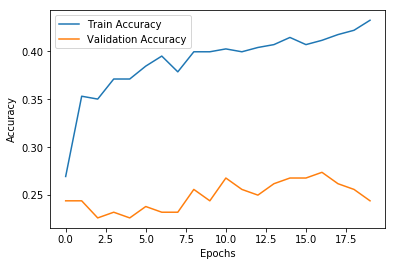

In [12]:
plt.plot(history_AN.history['acc'], label='Train Accuracy')
plt.plot(history_AN.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()